### 安裝套件

In [ ]:
!pip install requests

In [ ]:
!pip install feedparser

In [ ]:
!pip install lxml

In [ ]:
!pip install jieba

In [ ]:
!pip install wordcloud

### 下載對繁體分詞更好的辭典檔 (jieba原廠提供)
`dict.txt.big`

In [ ]:
!wget https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big -O jieba_data/dict.txt.big

# 解析 RSS
feedparser是python中最常用的RSS程序库，使用它我们可轻松地实现从任何 RSS 或 Atom 订阅源得到标题、链接和文章的条目。

In [1]:
import feedparser

rss_url = "https://money.udn.com/rssfeed/news/1001/5588/10511?ch=money"
newsFeed = feedparser.parse(rss_url)
print(newsFeed)

{'bozo': True, 'entries': [{'title': '北京學者：拜登「絕地反擊」開始  中國不可低估', 'title_detail': {'type': 'text/plain', 'language': None, 'base': 'https://money.udn.com/rssfeed/news/1001/5588/10511?ch=money', 'value': '北京學者：拜登「絕地反擊」開始  中國不可低估'}, 'links': [{'rel': 'alternate', 'type': 'text/html', 'href': 'https://money.udn.com/money/story/10511/5361303'}], 'link': 'https://money.udn.com/money/story/10511/5361303', 'published': 'Fri, 02 Apr 2021 11:00:26 +0800', 'published_parsed': time.struct_time(tm_year=2021, tm_mon=4, tm_mday=2, tm_hour=3, tm_min=0, tm_sec=26, tm_wday=4, tm_yday=92, tm_isdst=0), 'summary': '<p><img src="https://pgw.udn.com.tw/gw/photo.php?u=https://uc.udn.com.tw/photo/2021/04/02/realtime/12009118.jpg&amp;s=Y&amp;x=0&amp;y=0&amp;sw=1279&amp;sh=853&amp;sl=W&amp;fw=180&amp;exp=3600" /><p>美國總統拜登上台後，美中持續針鋒相對。中國學者時殷弘近日撰文分析，拜登政府已將中國定義為唯一的全面敵手和競爭者，「『絕地...</p>', 'summary_detail': {'type': 'text/html', 'language': None, 'base': 'https://money.udn.com/rssfeed/news/1001/5588/10511?ch=money', 'v

### 查看entries裡，每個title、 url 

In [2]:
i = 1
for e in newsFeed['entries']:
    title = e['title']
    link_url = e['links'][0]['href']
    
    print("%s, %s, %s"%(i, title, link_url))
    i = i + 1

1, 北京學者：拜登「絕地反擊」開始  中國不可低估, https://money.udn.com/money/story/10511/5361303
2, 美貿易報告 矛頭對準中國, https://money.udn.com/money/story/10511/5360837
3, 美無意取消加徵關稅  中國商務部籲對話協商, https://money.udn.com/money/story/10511/5360263
4, 中立態度挨轟後 達美可口可樂批喬州限縮投票法, https://money.udn.com/money/story/10511/5359691
5, 波音：美中貿易不應與人權等糾紛混為一談, https://money.udn.com/money/story/10511/5359437
6, 美貿易報告：全球鋼鋁等產能過剩 中國是禍首, https://money.udn.com/money/story/10511/5358932
7, 美貿易報告：全球鋼鋁等產能過剩 中國是禍首, https://money.udn.com/money/story/10511/5358932
8, 佛洛伊德最後9分鐘 白警殺人案續審壓頸影片呈堂, https://money.udn.com/money/story/10511/5358829
9, 世衛稱疫情源頭動物傳人 蓬佩奧：中共撐腰騙局, https://money.udn.com/money/story/10511/5356318
10, 華為中興設備禁購令有漏洞 美FCC委員籲防堵, https://money.udn.com/money/story/10511/5355808
11, 戴琪：美國還沒準備好取消中國進口關稅, https://money.udn.com/money/story/10511/5351479
12, 戴琪：尚未準備好取消中國關稅 對貿易談判持開放態度, https://money.udn.com/money/story/10511/5350531
13, 布林肯暗示 拜登政府不會因疫情懲罰中國, https://money.udn.com/money/story/10511/5350433
14, 中國抵制拒用新疆棉  白宮：國際社會應反對, https://mone

#### 解析html可以參考 https://lxml.de/lxmlhtml.html

### 開始取得每篇新聞文章

In [9]:
import requests
from lxml import etree
from io import StringIO
import time
import random
import jieba
import pandas as pd


#設定 request header
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"
my_headers = {
    'User-Agent': user_agent,
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
    "accept-Language": "zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7",
    "accept-encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "cache-control": "no-cache",
    "Accept-Charset": "UTF8,utf-8;q=0.7,*;q=0.7"
}


#爬文：把所有新聞內容變成一整個文字串
each_article_text_list = []
for e in newsFeed['entries']:
    url = e['links'][0]['href']
#     print(url)
    
    r = requests.get(url, headers = my_headers)
    
    if r.status_code == 200:
        parse_tree = etree.parse(StringIO(r.text), etree.HTMLParser())
        article_elements = parse_tree.xpath('//*[@id="article_body"]//p')
        
        for a_part in article_elements:
            if type(a_part.text) is str:
                each_article_text_list.append(a_part.text.strip())
        
        sleep_time = random.randint(2,4) #隨機休息
#         print("sleep time: %s sec"%(sleep_time))
        time.sleep(sleep_time)
        
    all_article_text = ''.join(each_article_text_list)
    
print(all_article_text)

#結果寫入檔案 下次就不用重跑
with open ('./RSS_News.txt' , 'w' ) as f:
    f.write(all_article_text)
    

美國總統拜登上台後，美中持續針鋒相對。中國學者時殷弘近日撰文分析，拜登政府已將中國定義為唯一的全面敵手和競爭者，「『絕地反擊』似的激情已在開始迸發」，不可低估。中國國際關係學術編譯平台「國政學人」微信公眾號1日刊登人民大學國際關係學院教授時殷弘的評論文章，他在其中作上述分析。時殷弘指出，拜登政府對美中關係根本性質的界定，最正式、最直接地見於美國國務卿布林肯（AntonyBlinken）首次對外政策重要演講，即將中國定義為「美國唯一的全面（systemic）敵手和競爭者」。他分析，拜登（Joe Biden）政府會先部分遷就與說服「國會民主黨左派、共和黨建制派和共和黨民粹派」，加上部分說服與遷就歐洲盟國，同時依據「全部署方式」（all-agency approach）討論和協調對中政策，可謂「三重協調」。因此，時殷弘認為，拜登政府一段時間內將不理睬中國近來對美放話中的「軟成分」，並以「戰略耐心」等待中國方面就某些或個別重大問題「軟化」。他說，到美方理睬中國對美放話中的「軟成分」時，「其態勢大概將相當強硬，合作和『正常競爭』的範圍將被限定得相當有限，為此規定的條件大多將相當嚴苛。」時殷弘也提到，美國軍方和政府正在醞釀戰略兵力部署方式的重大變更，這與中國戰略軍力騰升形勢下對中備戰密切相關。他並引述美聯社2月17日的分析報導指出，這項變更的要旨是「不受攜有政治、財政和安全代價的恆定基地制約」，「依照較難預料的周轉和以較小的集群部署兵力，令中國失衡」。他並表示，即使拜登政府的對中態勢被國際輿論普遍公認為甚強硬，但它仍受到共和黨人為主的美國「反華民意」往更強硬方向催逼。時殷弘也提到，拜登入主白宮剛兩月餘，接種2019冠狀病毒疾病（COVID-19）疫苗的人口3月中旬已占全美25%以上，4月底有可能達到約65%；1.9兆美元救市款已由國會兩院通過，普遍預測美國2021年國內生產毛額（GDP）成長率很可能超過中國。他並指出，美國內部的嚴重撕裂已有所緩解，拜登政府「與時俱進」的調整已在大做，拉攏國際人心的努力進展明顯，較省錢又較高效的備戰方式正在開始。「『絕地反擊』似的激情已在開始迸發」。因此，時殷弘強調，中國切勿低估拜登政府的能力和已有成就，須就對手的綜合實力和潛能持經久的開放性觀察方式。「應當記住蘇軾所言，『恃大而不戒，則輕敵而屢敗；知小而自畏，則深謀而必克』。」美國貿易代表署（U

In [11]:
#使用指定辭典檔
jieba.set_dictionary('jieba_data/dict.txt.big')

#進行jieba分詞
with open ('./RSS_News.txt' , 'r' ) as f:
    all_article_text= f.read()
seg_words_list = jieba.lcut(all_article_text)
print(seg_words_list[0:100])

#將每個詞都變成 seg_word欄位裡的一筆資料
seg_df = pd.DataFrame(seg_words_list, columns=['seg_word'])
print(seg_df)

Building prefix dict from /home/jovyan/work/06 Text_wordcloud/jieba_data/dict.txt.big ...
Loading model from cache /tmp/jieba.ua7fe3492a0c9aeb6416c4783f2c60a50.cache
Loading model cost 3.144 seconds.
Prefix dict has been built successfully.


['美國', '總統', '拜', '登上', '台', '後', '，', '美', '中', '持續', '針鋒相對', '。', '中國', '學者', '時', '殷弘', '近日', '撰文', '分析', '，', '拜登', '政府', '已將', '中國', '定義', '為', '唯一', '的', '全面', '敵手', '和', '競爭者', '，', '「', '『', '絕地', '反擊', '』', '似的', '激情', '已', '在', '開始', '迸發', '」', '，', '不可', '低估', '。', '中國', '國際', '關係', '學術', '編譯', '平台', '「', '國政', '學人', '」', '微信', '公眾號', '1', '日', '刊登', '人民大學', '國際關係學院', '教', '授時', '殷弘', '的', '評論', '文章', '，', '他', '在', '其中', '作', '上述', '分析', '。', '時', '殷弘', '指出', '，', '拜登', '政府', '對', '美中關係', '根本', '性質', '的', '界定', '，', '最', '正式', '、', '最', '直接', '地', '見於']
     seg_word
0          美國
1          總統
2           拜
3          登上
4           台
...       ...
7935       總統
7936       川普
7937        的
7938       提醒
7939        。

[7940 rows x 1 columns]


#### 準備一個利用stop word過濾調不想要的詞，因為下面文字雲會用來比較
stop word裡有一些比較沒意義又很常出現的詞 ex: 的、了...

In [12]:
#stop word
with open(file='jieba_data/stop_words.txt', mode='r', encoding='utf-8') as file:
    stop_words = file.read().split('\n')


#分詞
seg_stop_words_list = []
seg_words_list = jieba.lcut(all_article_text)
for term in seg_words_list:
    if term not in stop_words:
        seg_stop_words_list.append(term)
        
# print(seg_stop_words_list)

### 載入繪圖相關的 library

In [37]:
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud

print(matplotlib.matplotlib_fname())

/opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc


## 繪製文字雲 方法一 ( wordcloud.generate ) 
從結果發現，頻率最高的是”的”等之類的文字或符號都消失了，因為WordCloud.generate()同時做了 process_text and generate_from_frequencies 兩個function。

In [38]:
# wordcloud.generate 參數是吃文字內容，以空白為文字區隔

seg_words = ' '.join(seg_words_list)
# print(seg_words)

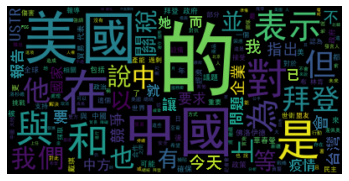

In [39]:
#用 SimHei字型呈現
wordcloud = WordCloud(font_path='fonts/SimHei.ttf').generate(seg_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

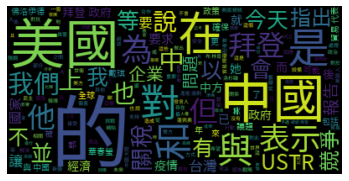

In [40]:
#用 TaipeiSansTCBeta-Regular字型呈現
wordcloud = WordCloud(font_path='fonts/TaipeiSansTCBeta-Regular.ttf').generate(seg_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

`[補充]WordCloud參數`

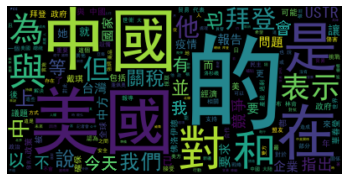

In [36]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wc = WordCloud(
  background_color='black',        #   背景顏色
  max_words=200,                   #   最大分詞數量
  mask=None,                       #   背景圖片
  max_font_size=None,              #   顯示字體的最大值
#   stopwords=STOPWORDS.add(word),   #   使用內置的屏蔽詞，再添加一個自訂變數word
  font_path='fonts/SimHei.ttf',             #   若為中文則需引入中文字型(.TTF)
  random_state=None,               #   隨機碼生成各分詞顏色
  prefer_horizontal=0.9)           #   調整分詞中水平和垂直的比例


seg_words = ' '.join(seg_words_list)

wordcloud = wc.generate(seg_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#輸出圖片
# wc.to_file(fig_path)


## 繪製文字雲 方法二(wordcloud.generate_from_frequencies) 用詞出現的頻率
- https://docs.python.org/zh-tw/3/library/collections.html

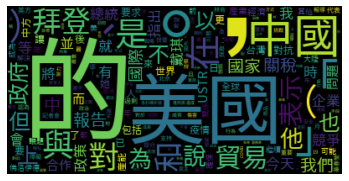

In [17]:
# [比較 1]
#沒有經過stop word 處理

from collections import Counter

#計算每個詞出現的次數 回傳成字典
seg_counter = Counter(seg_words_list)
# print(seg_counter)

wordcloud = WordCloud(font_path='fonts/TaipeiSansTCBeta-Regular.ttf').generate_from_frequencies(seg_counter)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

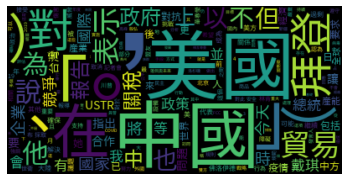

In [18]:
# [比較 2]
# 有經過stop word 處理

from collections import Counter

#計算每個詞出現的次數 回傳成字典
seg_stop_counter = Counter(seg_stop_words_list)
# print(seg_stop_counter)

wordcloud = WordCloud(font_path='fonts/TaipeiSansTCBeta-Regular.ttf').generate_from_frequencies(seg_stop_counter)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [補充] 如何用dataframe 處理數據

In [19]:
seg_df = pd.DataFrame(seg_words_list, columns=['seg_word'])
seg_df

,seg_word
0,美國
1,總統
2,拜
3,登上
4,台
...,...
7935,總統
7936,川普
7937,的
7938,提醒


In [20]:
#設立一個欄位count 讓他資料全是1，在利用.groupby 把相同詞合併

seg_df['count'] = 1
seg_freq_df = seg_df.groupby('seg_word').sum()
seg_freq_df

,count
seg_word,
,47
&,1
",",1
-,9
.,3
...,...
，,590
．,1
：,15
